# Sustainable Heating & Cooling project 

## Task 1
Simulate the Pasta cooking step of the pasta cooker 

#### Data and Package importation: 

In [1]:
from pylab import *
import matplotlib.pyplot as plt
import numpy as np
import Fluid_CP as FCP #calculation of  thermodynamic states
import pandas as pd

In [ ]:
# === Simulation parameters ===
sim_duration = 12 * 3600      # [s] total simulation time (12 h)

# === Pasta cooking parameters ===
m_pasta_batch   = 2.0         # [kg] pasta per batch
m_pasta_basket  = 0.5         # [kg] pasta per basket
n_baskets       = 4.0         # number of pasta baskets
t_env          = 20.0        # [°C] outside temperature
t_p_0           = 7.0         # [°C] initial pasta temperature
t_p_tgt  = 85.0        # [°C] cooking temperature 
t_w_init = 20.0        # [°C] ambient start temperature 
t_w_min     = 85.0        # [°C] lower control bound 
t_w_max     = 93.0        # [°C] upper control bound 
t_cook          = 7 * 60      # [s] cooking time per batch 
t_break         = 5 * 60      # [s] break between batches 

# === Thermal resistances ===
r_env_water   = 30.0          # environment ↔ water 
r_water_pasta = 15.0          # water ↔ pasta 

# === Specific heats ===
cp_water = 4.18e3             # [J/kg/K] water 
cp_pasta = 3.5e3              # [J/kg/K] pasta 

# === Cooker Dimensions ===
W_ext = 0.27 #[m]
L_ext = 0.47 #[m]
W_in = 0.10 #[m]
L_in = 0.20 #[m]
H_ext = 0.20 #[m]
H_in = 0.15 #[m]
wall_thick = 0.02 #[m]

#### Determine the required heating power during the pasta cooking phase

In [ ]:

#calling it with t_w= t_w_min for now
t_w= t_w_min
def required_heating_power(t_w,r_water_pasta,r_env_water,t_p_0,m_pasta_batch,cp_pasta):
    #for now I assume the the cooking température is 85 degrees
    P_loss = (t_w-t_env)/r_env_water
    P_pasta_max = (t_w-t_p_0)/r_water_pasta
    P_peak = P_loss + P_pasta_max
    
    P_pasta = m_pasta_batch*cp_pasta(t_w-t_p_0)
    E_pasta_avg = P_pasta/t_cook

    P_avg = P_pasta+P_loss

    return P_avg, P_peak, E_pasta_avg

In [ ]:
# le mettre sous la forme d'une fonction 
#all dimensions in [mm]
pipe_diameter = 6.35
lenght_available = 466
height_available = 48
width_available = 266

number_of_pipes = (lenght_available // pipe_diameter) * (height_available // pipe_diameter) 
max_heat_transfer_area = number_of_pipes * (pi * pipe_diameter * width_available) / 1000000 # [m^2]
print(f"Max heat transfer area: {max_heat_transfer_area:.2f} m^2, with {number_of_pipes:.0f} pipes")

Max heat transfer area: 2.71 m^2, with 511 pipes


### On-Off strategy

Heating on = 271.9999198060042 times, total duration = 12.0 minutes


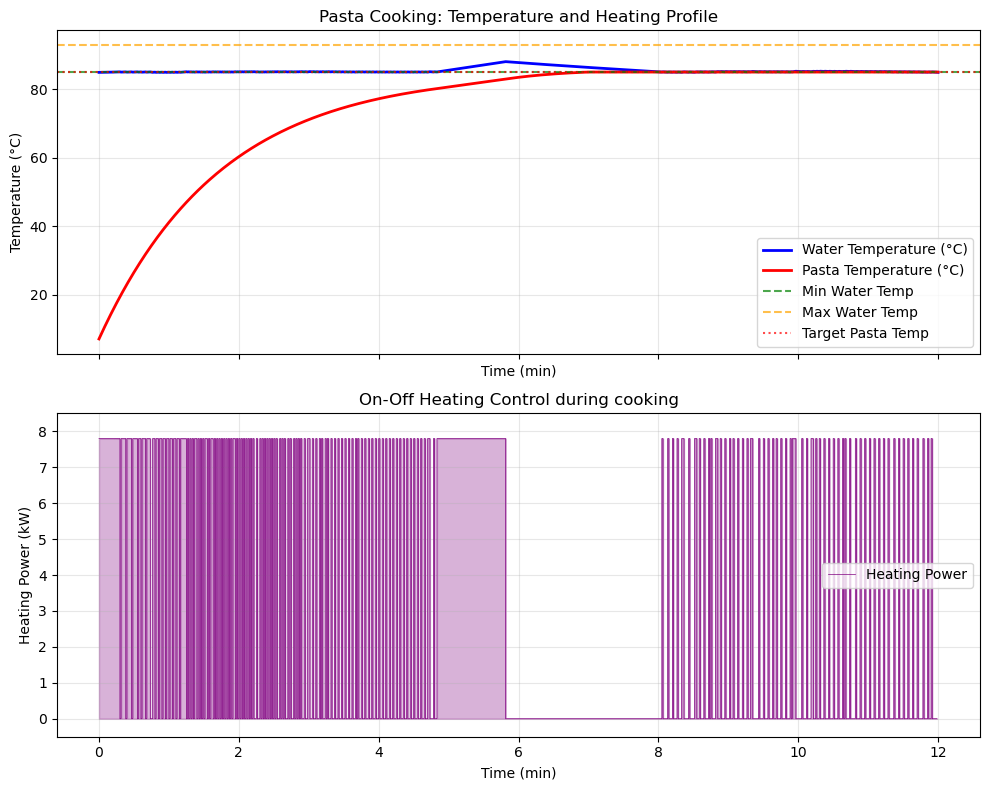


Heating Statistics:
Total cooking time: 12.0 minutes
Heating on time: 4.5 minutes (37.8%)
Total energy consumed: 0.035 kWh
Final pasta temperature: 85.1°C
Final water temperature: 85.0°C
Total energy used: 0.59 kWh


In [31]:
import numpy as np
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB

def optimize_on_off_control_cooking(
    m_w=24.54, c_w=4180.0,  # water mass [kg], heat capacity [J/(kg·K)]
    m_p=2.0, c_p=3500.0,   # pasta mass [kg], heat capacity [J/(kg·K)]
    R_env=30e-3,           # environmental resistance [K/W]
    R_wp=15e-3,            # water↔pasta resistance [K/W]
    T_inf=20.0,            # ambient [°C]
    Tw0=85.0, Tp0=7.0,      # initial temperatures [°C]
    T_w_min=85.0, T_w_max=93.0, T_p_target=85.0,
    P_max=7800.0,          # max heating power [W]
    duration=12*60.0, dt=1.0,  # total time [s], timestep [s]
    t_cook=7*60.0, t_break=5*60.0  # cooking time [s], break time [s]
    ):
    horizon = int(duration / dt)
    
    # Create model
    m = gp.Model("pasta_onoff")
    m.setParam('OutputFlag', 0)

    # Variables
    u = m.addVars(horizon, vtype=GRB.BINARY, name="u")  
    Tw = m.addVars(horizon+1, lb=-GRB.INFINITY, name="Tw")
    Tp = m.addVars(horizon+1, lb=-GRB.INFINITY, name="Tp")

    # Initial conditions
    m.addConstr(Tw[0] == Tw0, name="init_Tw")
    m.addConstr(Tp[0] == Tp0, name="init_Tp")

    # Dynamics
    for k in range(horizon):
        if k < int(t_cook / dt):
            heat_in = P_max * u[k]
            Q_loss = (Tw[k] - T_inf) / R_env
            Q_pasta = (Tw[k] - Tp[k]) / R_wp
            dTw = (heat_in - Q_loss - Q_pasta) / (m_w * c_w)
            m.addConstr(Tw[k+1] == Tw[k] + dt * dTw, name=f"dyn_w_{k}")

            dTp = Q_pasta / (m_p * c_p)
            m.addConstr(Tp[k+1] == Tp[k] + dt * dTp, name=f"dyn_p_{k}")
        else:
            heat_in = P_max * u[k]
            Q_loss = (Tw[k] - T_inf) / R_env
            Q_pasta = 0
            dTw = (heat_in - Q_loss - Q_pasta) / (m_w * c_w)
            m.addConstr(Tw[k+1] == Tw[k] + dt * dTw, name=f"dyn_w_{k}")
            m.addConstr(Tp[k+1] == Tp[k] , name=f"dyn_p_{k}")

        m.addConstr(Tw[k] >= T_w_min, name=f"min_Tw_{k}")
        m.addConstr(Tw[k] <= T_w_max, name=f"max_Tw_{k}")

    m.addConstr(Tp[int(t_cook / dt)] >= T_p_target, name="target_Tp")

    m.setObjective(gp.quicksum(u[k] for k in range(horizon)), GRB.MINIMIZE)
    m.optimize()

    u_opt = np.array([u[k].X for k in range(horizon)])
    Tw_opt = np.array([Tw[k].X for k in range(horizon+1)])
    Tp_opt = np.array([Tp[k].X for k in range(horizon+1)])
    
    return {
        'u': u_opt,
        'Tw': Tw_opt,
        'Tp': Tp_opt,
        'dt': dt,
        'duration': duration
    }

# Run optimization
result = optimize_on_off_control_cooking()
Tw = result['Tw']
Tp = result['Tp']
u_heating = result['u']  # heating on/off profile
dt = result['dt']
duration = result['duration']
t = np.arange(0, duration + dt, dt) / 60  # time in minutes
t_heating = np.arange(0, duration, dt) / 60  # time for heating profile (one less point)
print(f"Heating on = {np.sum(result['u'])} times, total duration = {duration/60:.1f} minutes")

# Calculate actual heating power
P_max = 7800.0  # W
heating_power = u_heating * P_max / 1000  # Convert to kW for better scale

# Plot temperatures and heating profile
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

# Temperature plot
ax1.plot(t, Tw, 'b-', linewidth=2, label='Water Temperature (°C)')
ax1.plot(t, Tp, 'r-', linewidth=2, label='Pasta Temperature (°C)')
ax1.axhline(y=85, color='g', linestyle='--', alpha=0.7, label='Min Water Temp')
ax1.axhline(y=93, color='orange', linestyle='--', alpha=0.7, label='Max Water Temp')
ax1.axhline(y=85, color='r', linestyle=':', alpha=0.7, label='Target Pasta Temp')
ax1.set_ylabel('Temperature (°C)')
ax1.set_xlabel('Time (min)')
ax1.set_title('Pasta Cooking: Temperature and Heating Profile')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Heating power plot
ax2.step(t_heating, heating_power, 'purple', linewidth=0.5, where='post', label='Heating Power')
ax2.fill_between(t_heating, 0, heating_power, step='post', alpha=0.3, color='purple')
ax2.set_xlabel('Time (min)')
ax2.set_ylabel('Heating Power (kW)')
ax2.set_title('On-Off Heating Control during cooking')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(-0.5, 8.5)

plt.tight_layout()
plt.show()

# Print some statistics
total_energy = np.sum(heating_power) * dt / 60 / 1000  # kWh
on_time = np.sum(u_heating) * dt / 60  # minutes
efficiency = (on_time / (duration/60)) * 100  # percentage

print(f"\nHeating Statistics:")
print(f"Total cooking time: {duration/60:.1f} minutes")
print(f"Heating on time: {on_time:.1f} minutes ({efficiency:.1f}%)")
print(f"Total energy consumed: {total_energy:.3f} kWh")
print(f"Final pasta temperature: {Tp[-1]:.1f}°C")
print(f"Final water temperature: {Tw[-1]:.1f}°C")

Energy_used = np.sum(heating_power) * dt / 3600  # kWh
print(f"Total energy used: {Energy_used:.2f} kWh")